#  Randall Lueck

# IST_652
# Final Project
# San Francisco Crime Data Interpretation and Prediction

# --------------------------------------------------------------------------------------------------------------
# Obtain the Data

In [1]:
#manipulation and visualization libraries
import numpy as np
import pandas as pd
from datetime import time
import matplotlib.pyplot as plt
import seaborn as sns

#GIS Libraries
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

In [2]:
#import the crime data
incidents = pd.read_csv('police-department-incidents.csv')

In [3]:
#view the layout of the imported data
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215024 entries, 0 to 2215023
Data columns (total 13 columns):
IncidntNum    int64
Category      object
Descript      object
DayOfWeek     object
Date          object
Time          object
PdDistrict    object
Resolution    object
Address       object
X             float64
Y             float64
Location      object
PdId          int64
dtypes: float64(2), int64(2), object(9)
memory usage: 219.7+ MB


# Scrub the Data

In [4]:
#drop NA and duplicate values
incidents.dropna(inplace = True)
incidents.drop_duplicates(inplace = True)
incidents.isna().sum()

IncidntNum    0
Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
Location      0
PdId          0
dtype: int64

In [5]:
#drop all items with locations outside of San Francisco (latitude above 40)
incidents = incidents[incidents.Y < 40]

In [6]:
%%time
#change date and time to proper datetime format
incidents.Date = pd.to_datetime(incidents.Date)
incidents.Time = pd.to_datetime(incidents.Time)

Wall time: 1min 48s


In [7]:
#set up year column
year_list = []
for year in incidents.Date.dt.year:
    year_list.append(year)

incidents['Year'] = np.array([year for year in year_list])

In [8]:
#remove any years with less than 50000 crimes (should only remove 2018).
incidents = incidents.groupby('Year').filter(lambda x : len(x) > 50000)

In [9]:
#set up season ranges using days of the year
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
# winter = everything else

season_list = []

for line in incidents.Date:
    line = int(line.strftime('%j'))
    if  line in spring:
        season_list.append('spring')
    elif line in summer:
        season_list.append('summer')
    elif line in fall:
        season_list.append('fall') 
    else:
        season_list.append('winter')

#record time of day to TOD column
incidents['Season'] = np.array([season for season in season_list])

In [10]:
#setup time-of-day (TOD) buckets
morning_start = time(5)
morning_end = time(11)

noon_start = time(12)
noon_end = time(16)

evening_start = time(17)
evening_end = time(21)   

time_list = []

#loop through Time to identify TOD
for line in incidents.Time.dt.time:
    if morning_start <= line <= morning_end:
        time_list.append('morning')
    elif noon_start <= line <= noon_end:
        time_list.append('afternoon')
    elif evening_start <= line <= evening_end:
        time_list.append('evening') 
    else:
        time_list.append('night')

#record time of day to TOD column
incidents['TOD'] = np.array([tod for tod in time_list])

# Examine the Data

In [11]:
#function to find the count of unique items in a specified column
def unique_count(col_name):
    unique, counts = np.unique(col_name, return_counts=True)
    return dict(zip(unique, counts))

In [12]:
#function to get mean crimes for a given category
def crimes_per_period(category):
    crimes = []
    for value in category:
        crimes.append(category.get(value))
    mean_crimes = sum(crimes) / len(crimes)
    return int(mean_crimes)

In [13]:
#count and display the unique year values with crime counts
crimes_per_year = unique_count(incidents.Year)
crimes_per_year

{2003: 149145,
 2004: 148110,
 2005: 142112,
 2006: 137853,
 2007: 137639,
 2008: 141311,
 2009: 139860,
 2010: 133523,
 2011: 132697,
 2012: 140847,
 2013: 152806,
 2014: 150128,
 2015: 156526,
 2016: 150882,
 2017: 154773}

In [14]:
#find mean crimes per year
print('Avg crimes per year: {}'.format(str(crimes_per_period(crimes_per_year))))

Avg crimes per year: 144547


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

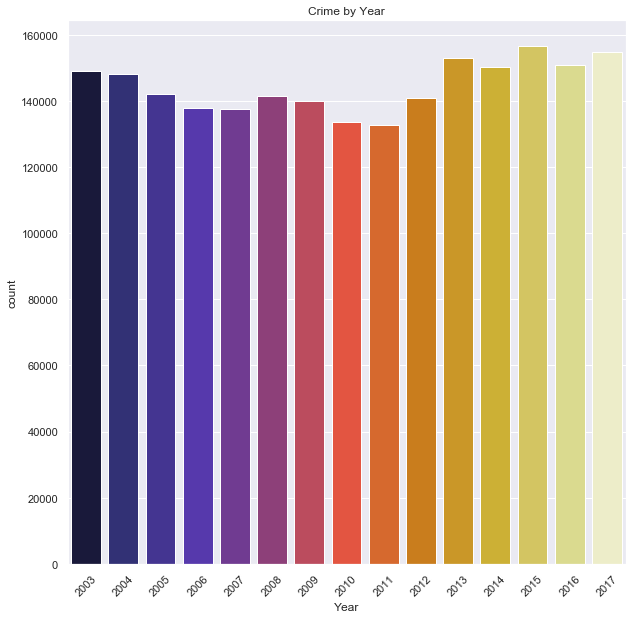

In [15]:
#graph yearly values
sns.set(rc={'figure.figsize':(10,10)})
ax = sns.countplot(x='Year', data=incidents, palette='CMRmap')
plt.title('Crime by Year')
plt.xticks(rotation=45)

In [16]:
#count the unique season values
crimes_per_season = unique_count(incidents.Season)
crimes_per_season

{'fall': 540380, 'spring': 544470, 'summer': 550143, 'winter': 533219}

In [17]:
#find mean crimes per year
print('Avg crimes per season: {}'.format(str(crimes_per_period(crimes_per_season))))

Avg crimes per season: 542053


Text(0.5, 1.0, 'Crime by Season')

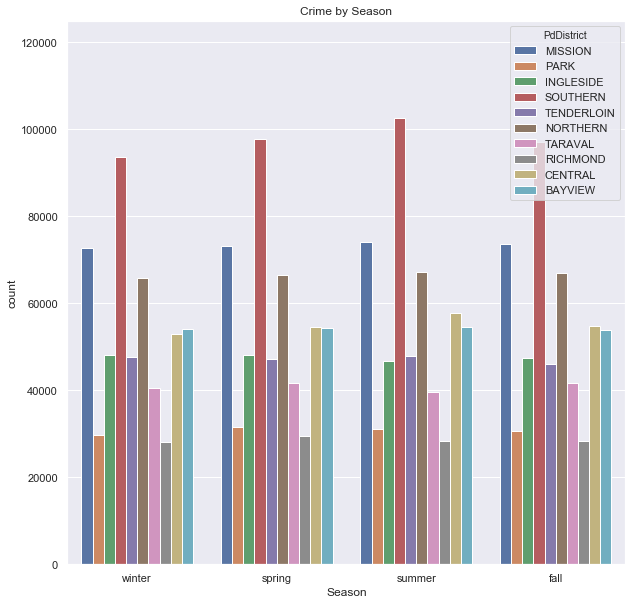

In [18]:
#get districts in order to make the department key the same across graphs
district_list = incidents.PdDistrict.unique()

#graph season values
ax = sns.countplot(x='Season',
                   hue = 'PdDistrict',
                   data=incidents,
                   order=['winter', 'spring', 'summer', 'fall'],
                   hue_order=district_list)

#make y-axis of year graph go to 125000
plt.ylim(0, 125000)
plt.title('Crime by Season')

In [19]:
tod_crimes = unique_count(incidents.TOD)
tod_crimes

{'afternoon': 499310, 'evening': 543653, 'morning': 396851, 'night': 728398}

In [20]:
#range of crime frequency for TOD
crimes = []
for value in tod_crimes:
    crimes.append(tod_crimes.get(value))
print('Crime frequency range for Time of Day: {}'.format(str(max(crimes) - min(crimes))))

Crime frequency range for Time of Day: 331547


Text(0.5, 1.0, 'Crime by TOD')

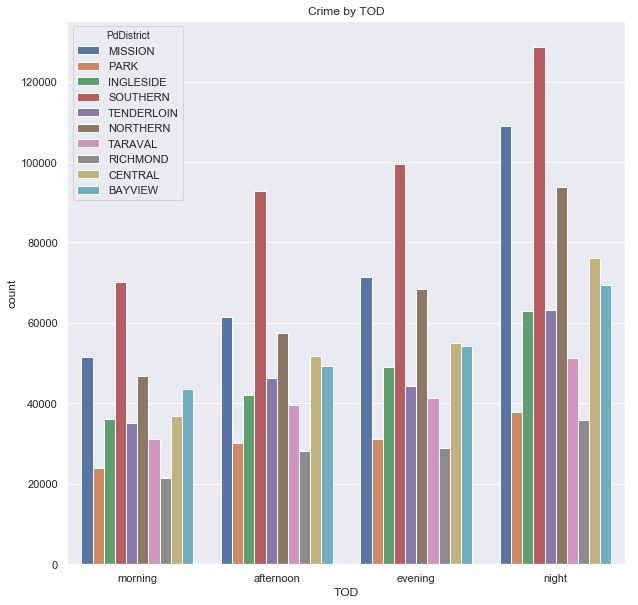

In [21]:
#graph time of day values
ax = sns.countplot(x="TOD",
                   hue = 'PdDistrict',
                   data=incidents,
                   order=['morning', 'afternoon', 'evening', 'night'],
                  hue_order=district_list)

plt.title('Crime by TOD')

In [22]:
#get count for crimes per day of the week
unique_count(incidents.DayOfWeek)

{'Friday': 330773,
 'Monday': 300033,
 'Saturday': 313636,
 'Sunday': 288468,
 'Thursday': 309415,
 'Tuesday': 308664,
 'Wednesday': 317223}

Text(0.5, 1.0, 'Crime by Day of the Week')

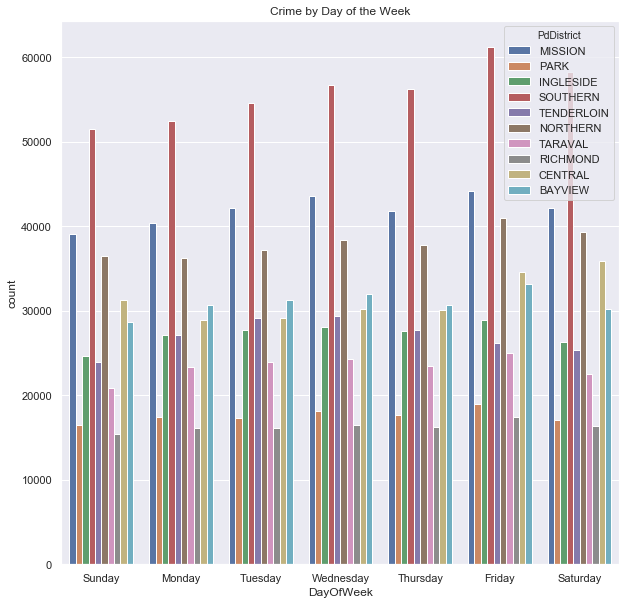

In [23]:
#force the order of days in a graph
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

#graph day of the week values
ax = sns.countplot(x="DayOfWeek",
                   hue = 'PdDistrict',
                   data=incidents,
                   order=days,
                  hue_order=district_list)

plt.title('Crime by Day of the Week')

In [24]:
#how many times does each crime occur?
unique_count(incidents.Category)

{'ARSON': 3834,
 'ASSAULT': 190086,
 'BAD CHECKS': 916,
 'BRIBERY': 796,
 'BURGLARY': 89444,
 'DISORDERLY CONDUCT': 9943,
 'DRIVING UNDER THE INFLUENCE': 5580,
 'DRUG/NARCOTIC': 118139,
 'DRUNKENNESS': 9742,
 'EMBEZZLEMENT': 2943,
 'EXTORTION': 729,
 'FAMILY OFFENSES': 1170,
 'FORGERY/COUNTERFEITING': 22855,
 'FRAUD': 40731,
 'GAMBLING': 339,
 'KIDNAPPING': 5272,
 'LARCENY/THEFT': 466787,
 'LIQUOR LAWS': 4069,
 'LOITERING': 2414,
 'MISSING PERSON': 63697,
 'NON-CRIMINAL': 233066,
 'OTHER OFFENSES': 303752,
 'PORNOGRAPHY/OBSCENE MAT': 56,
 'PROSTITUTION': 16651,
 'RECOVERED VEHICLE': 8716,
 'ROBBERY': 54793,
 'RUNAWAY': 4353,
 'SECONDARY CODES': 25188,
 'SEX OFFENSES, FORCIBLE': 11422,
 'SEX OFFENSES, NON FORCIBLE': 420,
 'STOLEN PROPERTY': 11626,
 'SUICIDE': 1274,
 'SUSPICIOUS OCC': 78727,
 'TREA': 14,
 'TRESPASS': 18933,
 'VANDALISM': 113262,
 'VEHICLE THEFT': 125112,
 'WARRANTS': 99747,
 'WEAPON LAWS': 21614}

In [25]:
#function to group crimes into mid-, high- and low-frequency distributions
def crime_rate(df, lower_freq, upper_freq):
    crime = df.groupby('Category').filter(lambda x : lower_freq < len(x) < upper_freq)
    return crime

In [26]:
#function to graph crimes by frequency.  builds off of the crime_rate function.
def graph_crimes(crime_freq, title):
    ax = sns.countplot(x='Category', hue = 'PdDistrict', data=crime_freq, hue_order=district_list)
    plt.title(title)
    plt.xticks(rotation=70)

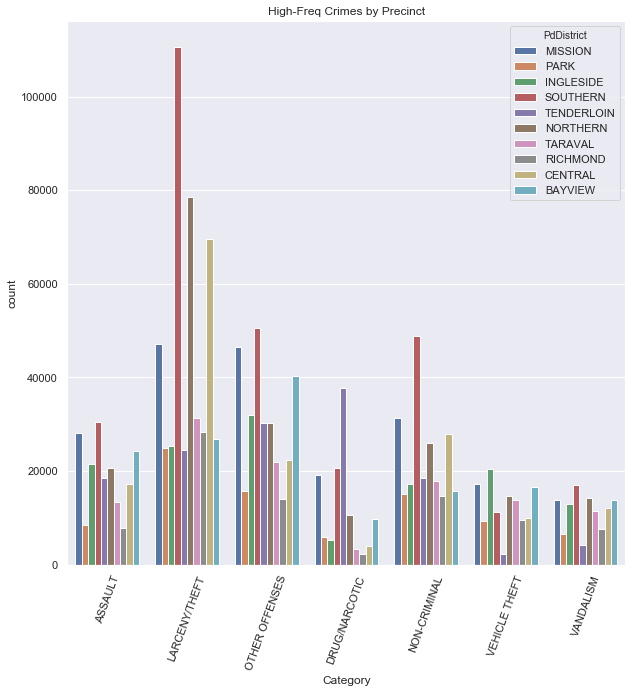

In [27]:
#view high-frequency crimes
high_freq_crimes = crime_rate(incidents, 100000, 500000)
graph_crimes(high_freq_crimes, 'High-Freq Crimes by Precinct')

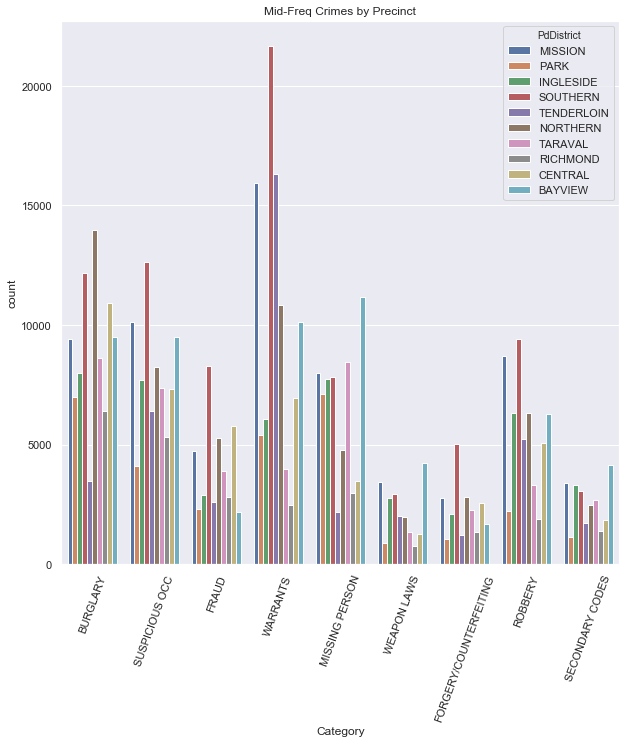

In [28]:
#view mid-frequency crimes
mid_freq_crimes = crime_rate(incidents, 20000, 100000)
graph_crimes(mid_freq_crimes, 'Mid-Freq Crimes by Precinct')

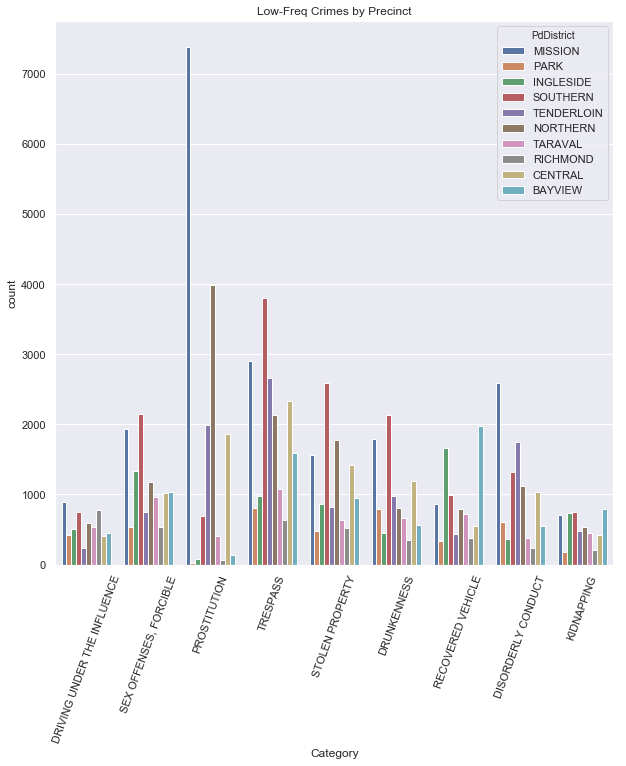

In [29]:
#view low-frequency crimes
low_freq_crimes = crime_rate(incidents, 5000, 20000)
graph_crimes(low_freq_crimes, 'Low-Freq Crimes by Precinct')

In [30]:
#view column names for easy reference
incidents.columns

Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId',
       'Year', 'Season', 'TOD'],
      dtype='object')

In [31]:
#remove unnecessary column names to save some memory when mapping
incidents = incidents.drop(['IncidntNum', 'Descript', 'Time', 'Resolution', 'Address', 'Location', 'PdId'], axis=1)

In [32]:
#sort the dataframe by District
incidents.sort_values(['PdDistrict', 'Date','Season', 'TOD', 'Category'], inplace=True, ascending=True)  
incidents.head()

,Category,DayOfWeek,Date,PdDistrict,X,Y,Year,Season,TOD
369554,LARCENY/THEFT,Wednesday,2003-01-01,BAYVIEW,-122.389100,37.765593,2003,winter,afternoon
710335,LARCENY/THEFT,Wednesday,2003-01-01,BAYVIEW,-122.390698,37.734797,2003,winter,afternoon
985133,LARCENY/THEFT,Wednesday,2003-01-01,BAYVIEW,-122.404383,37.762731,2003,winter,afternoon
1517571,LARCENY/THEFT,Wednesday,2003-01-01,BAYVIEW,-122.401097,37.724556,2003,winter,afternoon
632801,NON-CRIMINAL,Wednesday,2003-01-01,BAYVIEW,-122.387265,37.745600,2003,winter,afternoon


Text(0.5, 1.0, 'High-Freq Crimes')

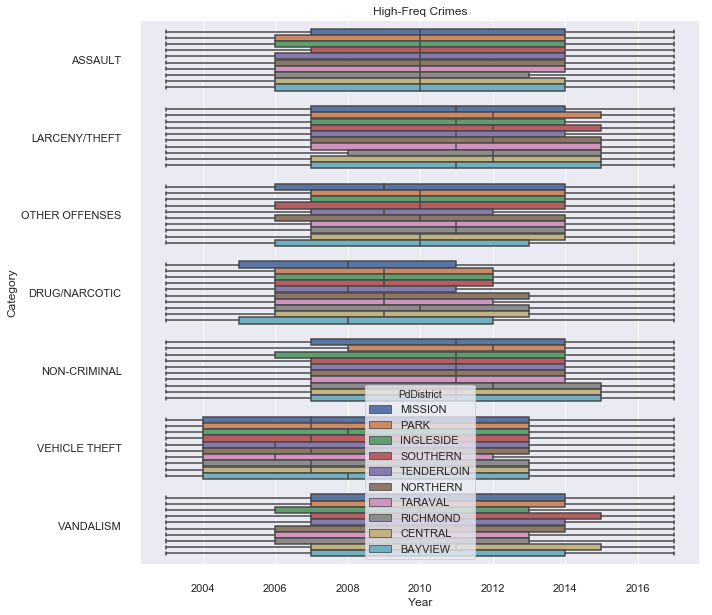

In [33]:
# Draw a nested boxplot to show crimes grouped by year
sns.boxplot(x='Year', y='Category',
            hue="PdDistrict",
            data=high_freq_crimes,
           hue_order=district_list)
sns.despine(offset=10, trim=True)
plt.title('High-Freq Crimes')

Text(0.5, 1.0, 'Mid-Freq Crimes')

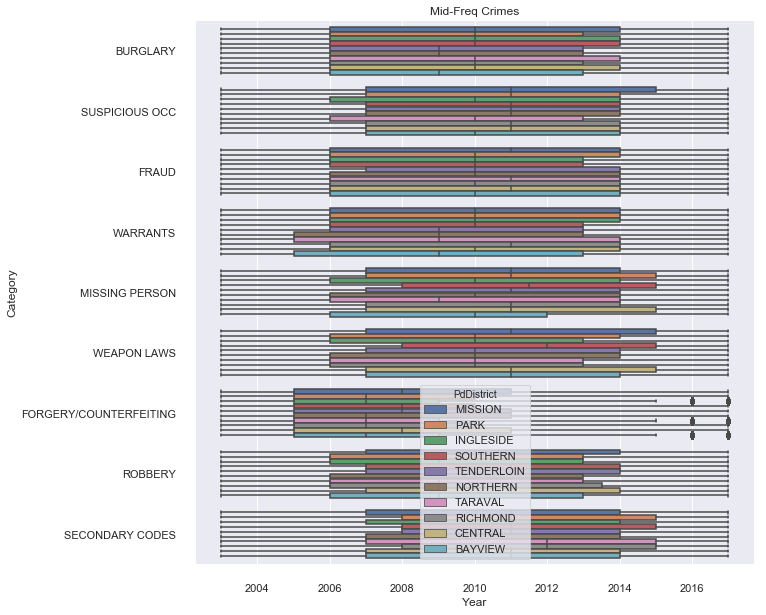

In [34]:
# Draw a nested boxplot to show crimes grouped by year
sns.boxplot(x='Year', y='Category',
            hue="PdDistrict",
            data=mid_freq_crimes,
           hue_order=district_list)
sns.despine(offset=10, trim=True)
plt.title('Mid-Freq Crimes')

Text(0.5, 1.0, 'Low-Freq Crimes')

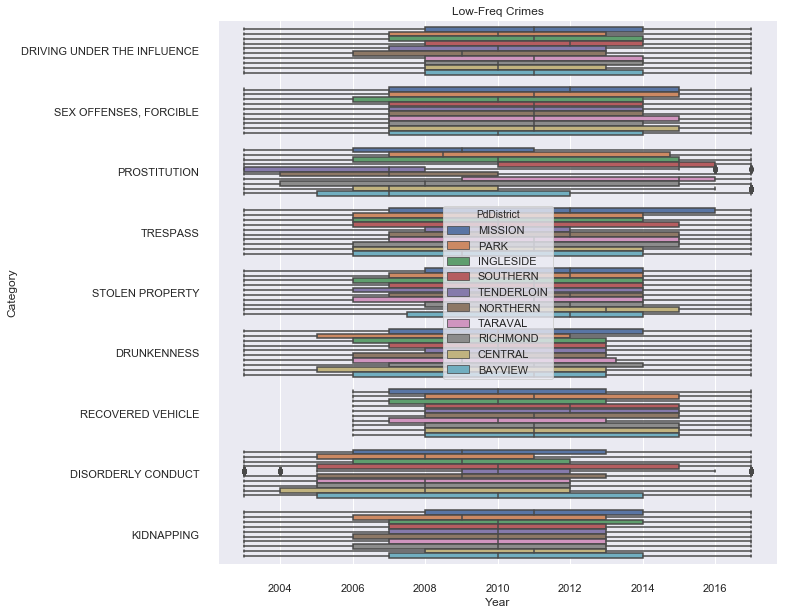

In [35]:
# Draw a nested boxplot to show crimes grouped by year
sns.boxplot(x='Year', y='Category',
            hue="PdDistrict",
            data=low_freq_crimes,
           hue_order=district_list)
sns.despine(offset=10, trim=True)
plt.title('Low-Freq Crimes')

# Model the Data

In [36]:
#SF map data
path = r'.\sfpd_districts\SFPD_Districts.shp'
map_df = gpd.read_file(path)
map_df = map_df.to_crs(epsg=4326)
map_df

,DISTRICT,COMPANY,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,SOUTHERN,B,87550.275142,100231.353916,9.134414e+07,(POLYGON ((-122.3918613892527 37.7942468087716...
1,BAYVIEW,C,163013.798332,144143.480351,2.013846e+08,POLYGON ((-122.3809828147303 37.76480021925649...
2,MISSION,D,40152.783389,40518.834235,8.062384e+07,POLYGON ((-122.4095391754818 37.76931771747006...
3,NORTHERN,E,56493.858208,50608.310321,8.278169e+07,POLYGON ((-122.4337921726589 37.80793010613561...
4,PARK,F,46307.776968,50328.913294,8.487896e+07,POLYGON ((-122.4395563105508 37.78313828284629...
5,RICHMOND,G,69991.465355,75188.628361,1.379640e+08,POLYGON ((-122.4412687149314 37.79148984345129...
6,INGLESIDE,H,74737.936295,74474.181164,1.935805e+08,POLYGON ((-122.4044981886719 37.74858097193449...
7,TARAVAL,I,75350.217521,73470.424000,2.846767e+08,POLYGON ((-122.4984166717482 37.70810460907064...
8,TENDERLOIN,J,12424.268969,18796.784185,1.107215e+07,POLYGON ((-122.4021713319469 37.78626013018994...
9,CENTRAL,A,64025.129073,67686.522865,5.595027e+07,POLYGON ((-122.4261203920909 37.80683853907644...


In [37]:
#function to label the map
def precinct_label(line, x_corr, y_corr):
    try:
        coord_list = list(map_df.geometry[line].exterior.coords)
    except:
        coord_list = list(map_df.geometry[line][0].exterior.coords)
    precinct = map_df.DISTRICT[line]
    point = round(len(coord_list)/10)
    lat = coord_list[point][0] - x_corr
    long = coord_list[point][1] - y_corr
    plotted = plt.text(lat, long, precinct)
    return(plotted)

def label_map():
    #looping cuts off precinct 6-9 so manually adding all map text
    precinct_label(0, 0.02, 0.02)
    precinct_label(1, 0.02, 0.02)
    precinct_label(2, 0.02, 0.0)
    precinct_label(3, 0.02, 0.0)
    precinct_label(4, 0.02, 0.0)
    precinct_label(5, 0.02, -0.01)
    precinct_label(6, 0.04, 0.0)
    precinct_label(7, -0.01, 0.0)
    precinct_label(8, 0.0, -0.005)
    precinct_label(9, -0.01, 0.02)

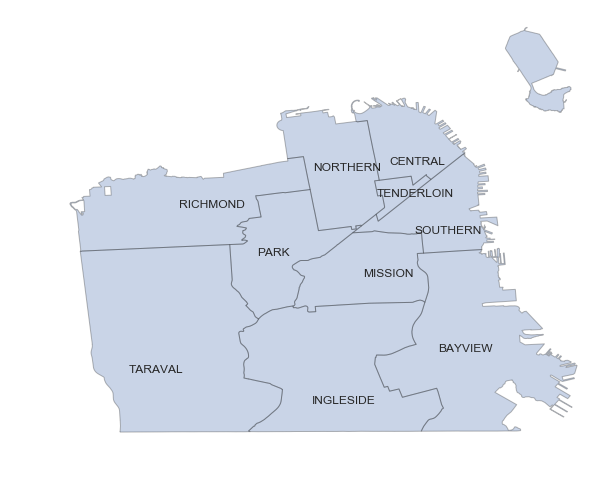

In [38]:
#draw the map
map_df.plot(figsize=(10, 10), alpha=0.3, edgecolor='k').axis('off')
label_map()

In [39]:
#join map and incident data
geo_rect = map_df.set_index('DISTRICT').join(incidents.set_index('PdDistrict'))
geo_rect.reset_index(inplace = True)
geo_rect.head()

,index,COMPANY,Shape_Leng,Shape_Le_1,Shape_Area,geometry,Category,DayOfWeek,Date,X,Y,Year,Season,TOD
0,BAYVIEW,C,163013.798332,144143.480351,2.013846e+08,POLYGON ((-122.3809828147303 37.76480021925649...,LARCENY/THEFT,Wednesday,2003-01-01,-122.389100,37.765593,2003,winter,afternoon
1,BAYVIEW,C,163013.798332,144143.480351,2.013846e+08,POLYGON ((-122.3809828147303 37.76480021925649...,LARCENY/THEFT,Wednesday,2003-01-01,-122.390698,37.734797,2003,winter,afternoon
2,BAYVIEW,C,163013.798332,144143.480351,2.013846e+08,POLYGON ((-122.3809828147303 37.76480021925649...,LARCENY/THEFT,Wednesday,2003-01-01,-122.404383,37.762731,2003,winter,afternoon
3,BAYVIEW,C,163013.798332,144143.480351,2.013846e+08,POLYGON ((-122.3809828147303 37.76480021925649...,LARCENY/THEFT,Wednesday,2003-01-01,-122.401097,37.724556,2003,winter,afternoon
4,BAYVIEW,C,163013.798332,144143.480351,2.013846e+08,POLYGON ((-122.3809828147303 37.76480021925649...,NON-CRIMINAL,Wednesday,2003-01-01,-122.387265,37.745600,2003,winter,afternoon


In [40]:
%%time
#change crime location to points to plot them
def make_point(row):
    return Point(row.X, row.Y)

#set each lat lon to coordinate points
points = geo_rect.apply(make_point, axis=1)

#add the points data to the dataframe
geo_rect = gpd.GeoDataFrame(geo_rect, geometry=points)

#adjust points for spherical shape
geo_rect.crs = {'init': 'epsg:4326'}
geo_rect.head()

Wall time: 1min 53s


In [41]:
#function to map crimes
def map_crime(df, year, tod, dayofweek):
    new_df = df[df.Year == year]
    new_df = new_df[df.TOD == tod]
    new_df = new_df[df.DayOfWeek == dayofweek]
    return new_df.plot(figsize=(10,10), column='Category', legend = True)

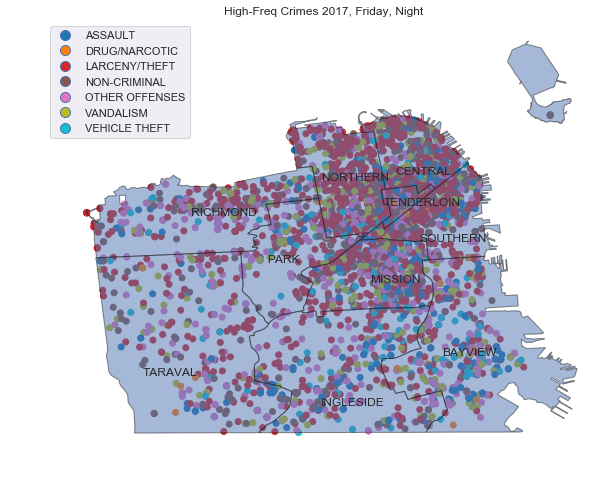

In [47]:
#map high-freq crimes by day and TOD
ax = high_freq_crimes = crime_rate(geo_rect, 100000, 500000)
ax = map_crime(high_freq_crimes, 2017, 'night', 'Friday')
map_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', ax=ax).axis('off')
plt.title('High-Freq Crimes 2017, Friday, Night')
label_map()

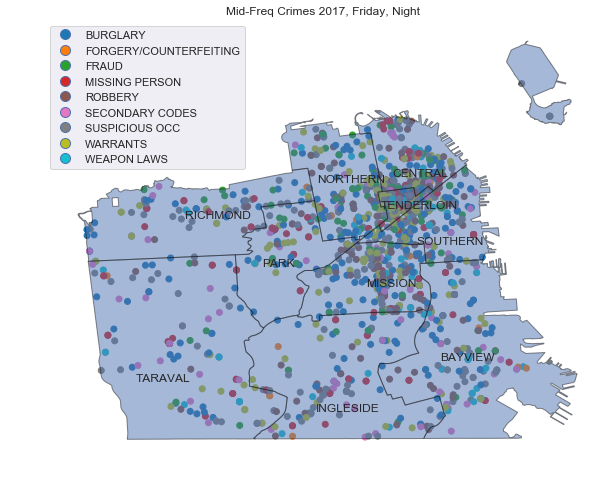

In [43]:
#map mid-freq crimes by day and TOD
ax = mid_freq_crimes = crime_rate(geo_rect, 20000, 100000)
ax = map_crime(mid_freq_crimes, 2017, 'night', 'Friday')
map_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', ax=ax).axis('off')
plt.title('Mid-Freq Crimes 2017, Friday, Night')
label_map()

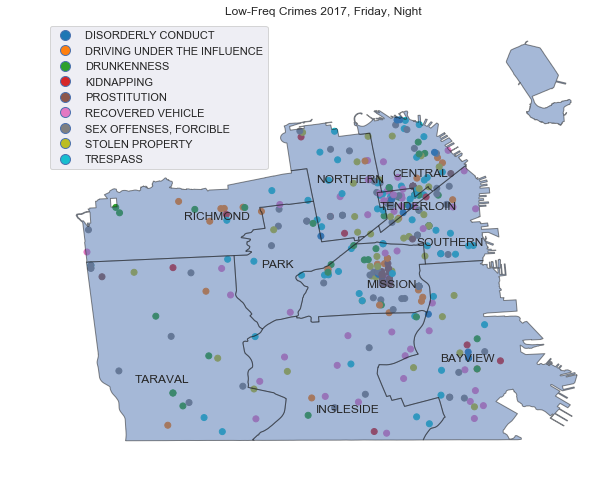

In [44]:
#map low-freq crimes by day and TOD
ax = low_freq_crimes = crime_rate(geo_rect, 5000, 20000)
ax = map_crime(low_freq_crimes, 2017, 'night', 'Friday')
map_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', ax=ax).axis('off')
plt.title('Low-Freq Crimes 2017, Friday, Night')
label_map()

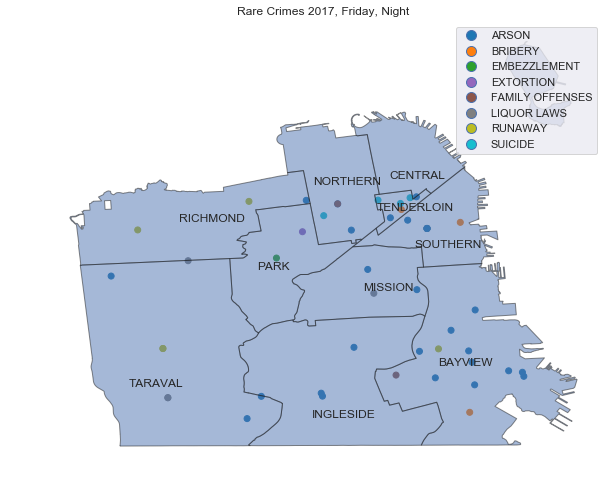

In [46]:
#map rare crimes by day and TOD
ax = rare_crimes = crime_rate(geo_rect, 1, 5000)
ax = map_crime(rare_crimes, 2017, 'night', 'Friday')
map_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', ax=ax).axis('off')
plt.title('Rare Crimes 2017, Friday, Night')
label_map()